# Gaussian process testing

I use this notebook to tinker with the Gaussian process procedure

In [1]:
using DataFrames, CSV, LinearAlgebra, Optim, StatsBase
using PythonPlot, Profile, ProfileCanvas
cd(dirname(@__FILE__))
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools

FIG_PATH = "./../figures"

    CondaPkg Found dependencies: /Users/elevien/.julia/packages/PythonCall/Nr75f/CondaPkg.toml
    CondaPkg Found dependencies: /Users/elevien/.julia/packages/PythonPlot/469aA/CondaPkg.toml
    CondaPkg Found dependencies: /Users/elevien/.julia/packages/PythonCall/WMWY0/CondaPkg.toml
    CondaPkg Found dependencies: /Users/elevien/.julia/packages/PythonPlot/oS8x4/CondaPkg.toml
    CondaPkg Dependencies already up to date


"./../figures"

# Example of running GP on SMR data

In [18]:
 # 1: LOAD PROCESSED DATA -----------------------------------------------------------------------------------------------
data = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);
data = data[(data.length .> 9),:];
lineages = unique(data.lineage);

In [20]:
GrowthTraceTools.get_gen_times!(df);

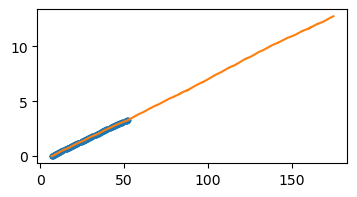

In [50]:
df = data[data.lineage .== lineages[9],:];
#df = df[df.position .>3,:]
df[:,:gen_time]= vcat([ones(length(df[df.position .==p,:].time))*(df[df.position .==p,:].time[end]-df[df.position .==p,:].time[1])
        for p in unique(df.position)]...);
df = df[df.cellcycle .=="i",:];
df[:,:y] = df[:,:lnM_sum] .- df[:,:lnM_sum][1]

# ------------------------------------------------------------------
# define model and setup
model = GrowthTraceTools.Matern32Model()
ops = Optim.Options(g_tol = 1e-2,iterations = 100,store_trace = true,show_trace = false);
alg = NelderMead()
pred_df = GrowthTraceTools.uniform_prediction_array(df,0.25) # this is the array of values to make predictions at
opt_inds = 1:5:min(2000,length(df.time))  # these are the indices used to by the optimizer
obs_inds = 1:1:length(df.time) # these are the indices used to make predictions (the actual function being smoothed)



fig, ax = subplots(figsize=(4,2))
ax.plot(df.time[opt_inds],df.y[opt_inds],".")
ax.plot(df.time,df.y,"-")
fig

In [51]:
Z,results = GrowthTraceTools.gp_run(df,model,opt_inds,obs_inds,pred_df,ops,alg)

(673×11 DataFrame
 Row │ matern32_cell  matern32_cell_var  matern32_cell_x  matern32_cell_x_var  ⋯
     │ Float64        Float64            Float64          Float64              ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    0.00103139        0.000376368       -0.194573              0.928504  ⋯
   2 │   -0.00449869      NaN                 -0.14902               0.928357
   3 │   -0.00863046        0.00037617        -0.107895              0.928285
   4 │   -0.0115081         0.00037605        -0.0712703             0.928256
   5 │   -0.0132771         0.000375847       -0.0391583             0.928249  ⋯
   6 │   -0.0140825         0.000375601       -0.0115141             0.92825
   7 │   -0.0140669         0.000375364        0.0117634             0.928251
   8 │   -0.0133689         0.000375179        0.0308286             0.92825
  ⋮  │       ⋮                ⋮                 ⋮                  ⋮           ⋱
 667 │    0.015353          0.

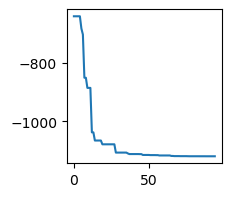

In [54]:
fig,ax = subplots(figsize=(2,2))
ax.plot(Optim.f_trace(results))
fig

In [55]:
out_df = Z

Row,matern32_cell,matern32_cell_var,matern32_cell_x,matern32_cell_x_var,matern32_flucs,matern32_flucs_var,matern32_flucs_x,matern32_flucs_x_var,time,position,linear
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00103139,0.000376368,-0.194573,0.928504,0.0785217,0.000376745,-0.00594175,3.31978e-5,6.76837,1.0,-0.0817791
2,-0.00449869,NaN,-0.14902,0.928357,0.0775383,0.000376326,0.000485161,1.86732e-5,7.01837,1.0,-0.0626382
3,-0.00863046,0.00037617,-0.107895,0.928285,0.0787346,0.000376275,0.00767076,1.72755e-5,7.26837,1.0,-0.0434973
4,-0.0115081,0.00037605,-0.0712703,0.928256,0.080912,0.000376172,0.0092739,1.65847e-5,7.51837,1.0,-0.0243563
5,-0.0132771,0.000375847,-0.0391583,0.928249,0.0830221,0.000375978,0.00703931,1.64254e-5,7.76837,1.0,-0.0052154
6,-0.0140825,0.000375601,-0.0115141,0.92825,0.0846691,0.000375738,0.00651452,1.64351e-5,8.01837,1.0,0.0139255
7,-0.0140669,0.000375364,0.0117634,0.928251,0.0861122,0.000375502,0.00398672,1.64579e-5,8.26837,1.0,0.0330665
8,-0.0133689,0.000375179,0.0308286,0.92825,0.0866596,0.000375311,0.0014451,1.64384e-5,8.51837,1.0,0.0522074
9,-0.0121211,0.000375065,0.045886,0.928245,0.087324,0.000375188,0.00376388,1.63623e-5,8.76837,1.0,0.0713483


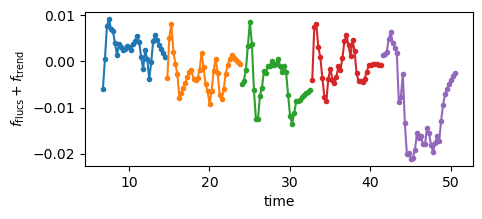

In [56]:

positions = unique(out_df.position)[1:5]
fig,ax = subplots(figsize=(5,2),sharey=true)
slope = cov(df[:,:lnM_sum],df[:,:time])/var(df[:,:time])
inter = mean(df[:,:lnM_sum]) - slope*mean(df[:,:time])
y_pred = slope*df[:,:time] .+ inter
df.time = df.time
df[:,:y]= df[:,:lnM_sum] .- y_pred
df = df[df.cellcycle .== "i",:]

for i in eachindex(positions)
    p = positions[i]
    d= out_df[out_df.position .== p,:]
    dr = df[df.position .== p,:]
    ax.plot(d.time,d.matern32_flucs_x,".-")
    #ax.plot(dr.time,dr.y,"C1-",fillstyle="none")
end

#ax.fill_between(data.time,data.matern32_flucs .+ data.matern32_cell  .- v,data.matern32_flucs .+  data.matern32_cell .+	v,alpha=.1)



#ax.plot(data_raw.time .- data_raw.time[1],y,label="data")
ax.legend(frameon=false)
ax.set_xlabel("time")
ax.set_ylabel(L"$f_{\rm flucs} + f_{\rm trend}$")

fig

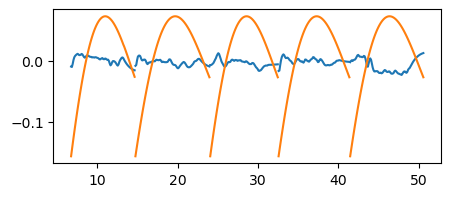

In [43]:
fig,ax = subplots(figsize=(5,2))
for i in eachindex(positions)
    p = positions[i]
    d= out_df[out_df.position .== p,:]
    ax.plot(d.time,d.matern32_flucs_x,"C0-")
    ax.plot(d.time,d.matern32_cell_x,"C1-")
end
fig
